# TMPS
This notebook explains the usage of the TMPS algorithm. The algorithm's purpose is to evolve states, represented as a one dimensional chain, in time. The state can be of the form MPS, MPO or PMPS and the Hamiltonian must be comprised of terms acting on single sites and terms acting on two adjacent sites. In addition to reading this notebook, make sure to also have a look at the [introduction](https://github.com/MoritzLange/py-tedopa/blob/master/examples/introduction.ipynb). To understand how TMPS and in particular this implementation works internally, read chapter 7 of [this paper from Schollwöck](https://doi.org/10.1016/j.aop.2010.09.012).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mpnum as mp
from tedopa import tmps

## Ising Model
The following will explain how to use the TMPS algorithm in `tmps.py` using the example of the transverse Ising model, since it is a well-known and convenient setup.

The function the user interacts with is called `tmps.evolve()`. In order to call it, the input parameters need to be defined and configured first.

Let's start with the initial quantum mechanical state. It must be of type `mpnum.MPArray` and can be an MPS, MPO or PMPS. To keep the example easy let us create an MPO comprised of four spins, which are all excited. The variable `method` hence has to be set to `'mpo'`, so that the program knows what it's dealing with.

In [2]:
array = np.zeros((16, 16))
array[0, 0] = 1
state = tmps.matrix_to_mpo(array, [[2, 2]] * 4)

method = 'mpo'

Above approach just generates a density matrix as a numpy.ndarray and turns it into an MPO using the function `tmps.matrix_to_mpo()`. This is a shortcut for generating MPOs from density matrices, but it will not work for larger systems since their full density matrices are too big to be stored. To find out how to generate states (not only MPOs, also MPSs and PMPSs) more flexibly and for large systems please read the [mpnum introduction](https://github.com/dseuss/mpnum/blob/master/examples/mpnum_intro.ipynb).

The Hamiltonian in our case is &sum;<sub>i</sub> B &sigma;<sub>x</sub><sup>i</sup> + &sum;<sub>i</sub> J (&sigma;<sub>z</sub><sup>i</sup> &otimes; &sigma;<sub>z</sub><sup>i+1</sup>).

The simplest way to pass a Hamiltonian to `evolve()` is to pass just one term which acts on every single site and one term which acts on every pair of adjacent sites. This suffices in our case and it is how we'll do it here. But if you have a different term for every different site or pair of adjacent sites, you can provide those too. Have a look at the documentation of `evolve()` to learn more.

In [3]:
B = 1
J = 1
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])

hamiltonians = [B * sx, J * np.kron(sz, sz)]


The TMPS algorithm is based on Trotter decomposition. Therefore, a number of Trotter slices and a Trotter order need to be set. Currently, Trotter of second and fourth order are implemented. After each Trotter iteration, compression of the resulting state takes place. For this, the variable `trotter_compr` needs to be set. It is directly passed to mpnum and hence has to be of the form required by mpnum.

The terms in the time evolution operator for one Trotter step are calculated as MPOs and can also be compressed before starting the Trotter iterations. This is accomplished by setting the `compr` variable. Be careful with that (don't set the compression too high, see **Pitfalls** in the introduction notebook).

In [4]:
num_trotter_slices = 100
trotter_order = 4
trotter_compr = dict(method='svd', relerr=1e-20)
compr = dict(method='svd', relerr=1e-20)

Finally, the times for which the evolved states are requested and also the subsystems of the whole state which are to be returned at these times need to be configured. The algorithm will take the largest/latest time, let's call it t<sub>f</sub>, and the number of Trotter slices, let's call that n, and size one Trotter step so that it evolves the system for a time step of t<sub>f</sub>/n. While applying that one Trotter step n times, it will store the system (or subsystems) on the way for smaller requested times. This means that the actual times the state is calculated at might differ slightly from those requested. The algorithm will look for the closest multiple of t<sub>f</sub>/n in each case.

The subsystems parameter can also be omitted. In that case, the full state will be returned for each time in ts.

In [5]:
ts = list(np.linspace(0,10,50))
# subsystems = [0, 4] # Passing this to evolve() will not change the results, since it would request the full state for every time in ts

A verbose parameter can also be set to control the amount of output generated. It can be set to values between 0 and 3. 0 leads to no output at all, 1 will suffice to keep track of the progress, 2 enables the user to monitor bond dimensions of the state and 3 will lead to the program printing the bond dimensions of the state after every Trotter iteration.

In [6]:
v = 1

Now all the required parameters are defined, and `tmps.evolve()` can be called:

In [7]:
times, sites, evolved_states = \
    tmps.evolve(state=state,
                hamiltonians=hamiltonians,
                num_trotter_slices=num_trotter_slices,
                method=method,
                trotter_compr=trotter_compr,
                trotter_order=trotter_order,
                compr=compr,
                ts=ts,
                v=v)

Time evolution operator for Trotter slice calculated, starting Trotter iterations...
1 Trotter iterations finished...
4 Trotter iterations finished...
9 Trotter iterations finished...
16 Trotter iterations finished...
25 Trotter iterations finished...
36 Trotter iterations finished...
49 Trotter iterations finished...
64 Trotter iterations finished...
81 Trotter iterations finished...
100 Trotter iterations finished...
Done with time evolution


The variable `times` contains a list of times, `sites` contains a list indicating which subsystem was returned at each time and `evolved_states` naturally contains the evolved states at each of the times. The first and last ten entries of these lists look like this:

In [8]:
print("Head:", times[:10:])
print("Tail:", times[-10::])

Head: [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8]
Tail: [8.0, 8.200000000000001, 8.4, 8.6, 8.8, 9.0, 9.200000000000001, 9.4, 9.600000000000001, 9.8]


In [9]:
print("Head:", sites[:10:])
print("Tail:", sites[-10::])

Head: [[0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4]]
Tail: [[0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4], [0, 4]]


The evolved state (let's call it &rho;) can then be analysed in any arbitrary way. Let us for example create, as an observable, the Kronecker sum A = &sigma;<sub>z</sub>&oplus;&sigma;<sub>z</sub>&oplus;&sigma;<sub>z</sub>&oplus;&sigma;<sub>z</sub>. Then calculate tr(A&rho;) and plot the result over time:

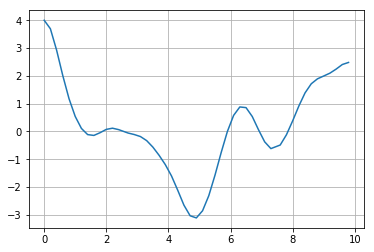

In [10]:
sz_mpo = tmps.matrix_to_mpo(sz, [[2,2]])
observable = mp.local_sum([sz_mpo] * 4)

outcomes = [mp.trace(mp.dot(state, observable))
               for state in evolved_states]
outcomes = np.real(outcomes)
plt.plot(times, outcomes)
plt.grid()
plt.show()